In [26]:
import json
import pandas as pd
from pathlib import Path
# name_file = 'prototypes/merged_inference_stats_7x7_color_tymek'
name_file = 'prototypes/toys_pointnet_epic_dislocated_grid_7_15_to_3_merged_inference_stats_julka'
in_path = Path(f"{name_file}.json")      # <-- set to your path
out_path = Path(f"{name_file}.csv") # output CSV path

with in_path.open("r") as f:
    data = json.load(f)

rows = []
for sample_name, channels in data.items():
    parts = sample_name.split("_")
    class_name = "_".join(parts[:-1]) if len(parts) > 1 else sample_name
    id_number = parts[-1] if len(parts) > 1 else ""
    
    for ch, info in channels.items():
        channel_str = str(ch).zfill(4)
        classes = info.get("classes", [])
        samples = info.get("samples", [])

        n = len(classes)
        for r in range(1, n + 1):
            predicted_class = classes[r - 1]
            samples_inside = samples[r - 1]

            rows.append({
                "class_name": class_name,
                "id_number": id_number,
                "sample_name": sample_name,
                "rank": r,
                "channel": channel_str,
                "prototype_class": predicted_class,
                "samples": samples_inside
            })

df = pd.DataFrame(rows, columns=["class_name", "id_number", "sample_name", "rank", "channel", "prototype_class", 'samples'])
df.to_csv(out_path, index=False)
print(f"Wrote {len(df)} rows to {out_path}")


Wrote 1125 rows to prototypes/toys_pointnet_epic_dislocated_grid_7_15_to_3_merged_inference_stats_julka.csv


In [27]:
df.head(10)

,class_name,id_number,sample_name,rank,channel,prototype_class,samples
0,tree,001,tree_001,1,0865,4,127
1,tree,001,tree_001,2,0865,8,329
2,tree,001,tree_001,3,0865,8,328
3,tree,001,tree_001,4,0865,9,363
4,tree,001,tree_001,5,0865,8,354
5,tree,001,tree_001,1,0910,8,354
6,tree,001,tree_001,2,0910,8,333
7,tree,001,tree_001,3,0910,8,353
8,tree,001,tree_001,4,0910,8,346
9,tree,001,tree_001,5,0910,9,396


In [28]:
df['prototype_class'].value_counts()

prototype_class
8     335
6     270
9     169
2     128
7     127
4      38
3      38
10     15
5       5
Name: count, dtype: int64

In [29]:
print(df)

     class_name id_number sample_name  rank channel prototype_class  samples
0          tree       001    tree_001     1    0865               4      127
1          tree       001    tree_001     2    0865               8      329
2          tree       001    tree_001     3    0865               8      328
3          tree       001    tree_001     4    0865               9      363
4          tree       001    tree_001     5    0865               8      354
...         ...       ...         ...   ...     ...             ...      ...
1120       sofa       014    sofa_014     1    0859               8      325
1121       sofa       014    sofa_014     2    0859               8      353
1122       sofa       014    sofa_014     3    0859               8      354
1123       sofa       014    sofa_014     4    0859               8      329
1124       sofa       014    sofa_014     5    0859               8      328

[1125 rows x 7 columns]


In [36]:
df.groupby('class_name')["prototype_class"].value_counts()

class_name  prototype_class
cup         6                  58
            2                  21
            9                  21
            7                  10
            8                   7
                               ..
tree        7                   9
            4                   5
            3                   3
            5                   1
            10                  1
Name: count, Length: 69, dtype: Int64

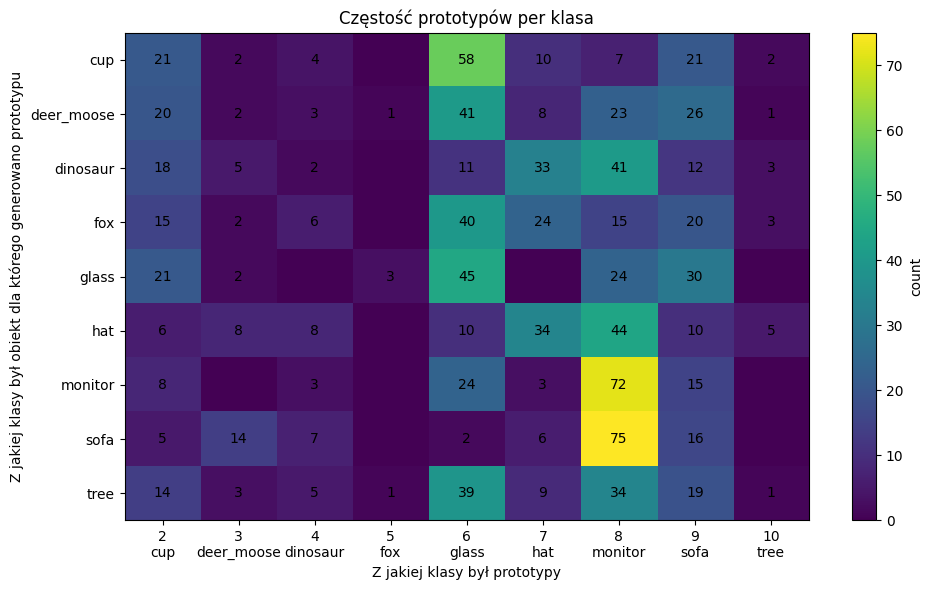

Tablica kształt: (9, 9)
Kolumny (ID): [2, 3, 4, 5, 6, 7, 8, 9, 10]


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- START: przygotowanie danych ---

# Upewnij się, że prototype_class jest liczbą całkowitą
df = df.copy()
df["prototype_class"] = pd.to_numeric(df["prototype_class"], errors="coerce").astype("Int64")

# Zbuduj tablicę zliczeń: wiersze=class_name, kolumny=prototype_class (ID)
ct = pd.crosstab(df["class_name"], df["prototype_class"])

# Wymuś pełny zakres kolumn 2..10 i wypełnij zera tam gdzie brak
all_ids = [2,3,4,5,6,7,8,9,10]
ct = ct.reindex(columns=all_ids, fill_value=0)

# Opcjonalnie posortuj klasy alfabetycznie
ct = ct.sort_index()

# --- END: przygotowanie danych ---

# Mapowanie ID -> nazwa
id_to_name = {
    2: "cup",
    3: "deer_moose",
    4: "dinosaur",
    5: "fox",
    6: "glass",
    7: "hat",
    8: "monitor",
    9: "sofa",
    10: "tree"
}

# Etykiety X: pokaż ID i nazwę (czytelniej)
x_labels = [f"{i}\n{id_to_name.get(i, str(i))}" for i in all_ids]

# Macierz do rysowania
M = ct.values  # shape: (n_classes, 9)

# --- RYSOWANIE MATPLOTLIB (bez seaborn) ---
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(M, aspect="auto")  # nie ustawiamy kolorów ręcznie

# Ticki i etykiety
ax.set_xticks(np.arange(ct.shape[1]))
ax.set_xticklabels(x_labels, rotation=0, ha="center")
ax.set_yticks(np.arange(ct.shape[0]))
ax.set_yticklabels(ct.index)

ax.set_xlabel("Z jakiej klasy był prototypy")
ax.set_ylabel("Z jakiej klasy był obiekt dla którego generowano prototypu")
ax.set_title("Częstość prototypów per klasa")

# Pasek kolorów
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("count")

# Adnotacje liczbami (jeśli chcesz, możesz wyłączyć pętlę)
for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        v = int(M[i, j])
        if v > 0:
            ax.text(j, i, str(v), ha="center", va="center")

plt.tight_layout()
plt.show()

# Diagnostyka, gdyby coś dalej nie grało:
print("Tablica kształt:", ct.shape)
print("Kolumny (ID):", list(ct.columns))


In [32]:
from IPython.display import display, HTML

a = df.groupby('class_name')["channel"].value_counts()
display(HTML(f"<div style='height:300px; overflow:auto;'>{a.to_frame().to_html()}</div>"))


In [33]:
df

,class_name,id_number,sample_name,rank,channel,prototype_class,samples
0,tree,001,tree_001,1,0865,4,127
1,tree,001,tree_001,2,0865,8,329
2,tree,001,tree_001,3,0865,8,328
3,tree,001,tree_001,4,0865,9,363
4,tree,001,tree_001,5,0865,8,354
...,...,...,...,...,...,...,...
1120,sofa,014,sofa_014,1,0859,8,325
1121,sofa,014,sofa_014,2,0859,8,353
1122,sofa,014,sofa_014,3,0859,8,354
1123,sofa,014,sofa_014,4,0859,8,329


In [34]:
most_frequent = list(df['samples'].value_counts().items())[:10]



In [35]:
for sample, count in most_frequent:
    print(f"Sample: {sample}, Count: {count}")
    print(df[df['samples'] == sample]['channel'].value_counts())
    print('\n')
    print(df[df['samples'] == sample]['prototype_class'].value_counts())
    print('\n')

    print(df[df['samples'] == sample]['class_name'].value_counts())

    print("-----")

# print(len(df[df['samples'].isin(most_frequent)]))
# df[df['samples'].isin(most_frequent)]['prototype_class'].value_counts()

Sample: 363, Count: 95
channel
0929    27
0577    23
0414    15
0865    14
0547    11
0515     5
Name: count, dtype: int64


prototype_class
9    95
Name: count, dtype: Int64


class_name
cup           20
tree          17
glass         15
fox           15
deer_moose    14
monitor       11
dinosaur       2
hat            1
Name: count, dtype: int64
-----
Sample: 70, Count: 84
channel
0929    27
0577    23
0414    15
0547    11
0515     5
0161     1
0848     1
0789     1
Name: count, dtype: int64


prototype_class
2    84
Name: count, dtype: Int64


class_name
cup           18
deer_moose    15
glass         15
tree          13
fox           12
monitor        8
dinosaur       3
Name: count, dtype: int64
-----
Sample: 249, Count: 76
channel
0929    27
0577    23
0414    15
0547    11
Name: count, dtype: int64


prototype_class
6    76
Name: count, dtype: Int64


class_name
cup           18
tree          12
deer_moose    12
fox           12
glass         12
monitor        8
dinosaur       2